<div class="alert alert-danger">
<i class='fa fa-exclamation-triangle'></i> &emsp; 
Warning! This notebook contains all the function needed to perform this project. 

You don't have to modify anything just run the notebook import in the Clouds_Formation noteook. 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import cv2
import copy

from matplotlib.lines import Line2D



from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion,CenterCrop

from copy import deepcopy

In [7]:
test_imgs_folder = 'test_images'
train_imgs_folder =  'train_images'
checkpoint_folder = 'checkpoints'

### Let's work on the dataframe

In [8]:
df = pd.read_csv('train-1.csv')
df['id_image'] = df['Image_Label'].apply(lambda row: row.split('_')[0])
df['cloud_type'] = df['Image_Label'].apply(lambda row: row.split('_')[1])
df = df.set_index('id_image')
df['ImageId'] = df['Image_Label'].apply(lambda row: row.split('_')[0])
df.drop(['Image_Label'], axis = 1, inplace=True)

In [9]:
df_train = df.ImageId.unique()
df_train = pd.DataFrame(df_train, columns=['ImageId'])
df_train.ImageId = df.ImageId.unique()

In [10]:
def mask_dict(img):
    mask = {}
    for i in range(4): 
        mask[df.cloud_type[img][i]] = df.EncodedPixels[img][i]
    return mask

In [11]:
df_train['Masks'] = df_train.apply(mask_dict, axis=1)

### RLE decode function

In [12]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(2100, 1400)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

### Random visualization on the train folder

In [13]:
def mask2contour(mask, width=5):
    w = mask.shape[1]
    h = mask.shape[0]
    
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    
    return np.logical_or(mask2,mask3) 

In [47]:
def random_visu_train():
    train = "train_images"
    random_name = random.choice([x for x in os.listdir(train)])
    img = plt.imread("train_images" + "/" + random_name)
    img = np.array(img)

    img_masks = df_train.loc[df_train['ImageId'] == random_name, 'Masks'].to_list()[0]
    print("filename: ",random_name)
    try:
        mask_fish =rle_decode(str(list(img_masks.values())[0]))
    except:
        mask_fish =  np.zeros((1400,2100))

    try:
        mask_flower =rle_decode(str(list(img_masks.values())[1]))
    except:
        mask_flower = np.zeros((1400,2100))

    try:
        mask_gravel =rle_decode(str(list(img_masks.values())[2]))
    except:
        mask_gravel = np.zeros((1400,2100))

    try:
        mask_sugar =rle_decode(str(list(img_masks.values())[3]))
    except:
        mask_sugar = np.zeros((1400,2100))
    ##Fish = Blue - Flower = Yellow - Gravel = Green - Sugar = Red
    for mask,i in zip([mask_fish, mask_flower, mask_gravel, mask_sugar], [(0,255,255), (255,255,0), 
                                                                         (0,255,0), (255,0,0)]):
        contour = mask2contour(mask)
        img[contour==1,:] = i
    plt.figure(figsize=(12,12))
    plt.imshow(img)
    colors = ['cyan', 'yellow', 'lime','red']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    labels = ['FIsh', 'Flower', 'Gravel','Sugar']
    plt.legend(lines, labels)
    plt.axis('off')

filename:  1d8ce67.jpg


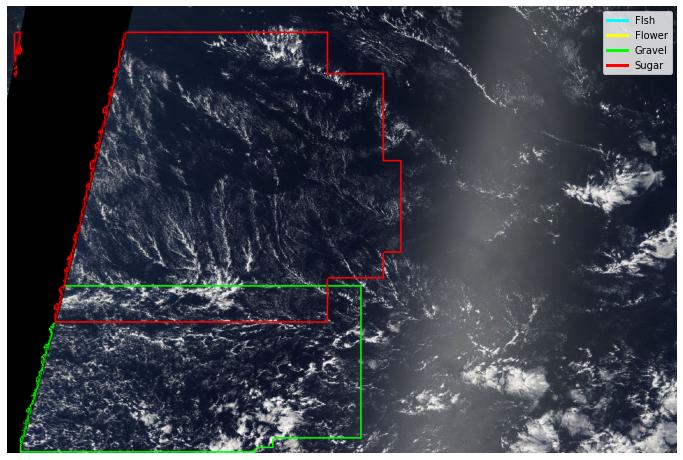

In [51]:
random_visu_train()

### Data generator

In [9]:
BATCH_SIZE = 16

In [10]:
input_height = 256
input_width = 256

output_height = 256
output_width = 256

In [11]:
albumentations_train = A.Compose([
    A.VerticalFlip(p=.5), #Effet miroir vertical
    A.Rotate(limit=20, interpolation = 0, p=.5), #Rotation 
    A.HorizontalFlip(p=.5),
    A.RandomSizedCrop(min_max_height=(156, 156), height=256, width=256, interpolation = 0), #Crop sur l'image
], p=.5, 
    additional_targets={'img' : 'image', 'mask_gravel': 'mask', 'mask_fish': 'mask','mask_flower': 'mask', 'mask_sugar': 'mask' })

In [12]:
class DataGenenerator(Sequence):
    def __init__(self, images_list=None, folder_imgs=train_imgs_folder, dataframe = df_train,
                 batch_size=BATCH_SIZE, shuffle=True, augmentation=None, is_test = False, output_height = output_height, output_width = output_width,
                 resized_height=input_height, resized_width=input_width, num_channels=3, num_classes = 4):
        # Taille du batch
        self.batch_size = batch_size
        # Variable pour le mélange aléatoire des images
        self.shuffle = shuffle
        # Gestion de la data augment
        self.augmentation = augmentation
        #Retourne la liste des images 
        if images_list is None:
            self.images_list = os.listdir(folder_imgs)
        else:
            self.images_list = deepcopy(images_list)
        # Nom du répertoire des images
        self.folder_imgs = folder_imgs
        # Nb d'itérations pour chaque epoch
        self.len = len(self.images_list) // self.batch_size
        # Hauteur de l'image redimensionnée
        self.resized_height = resized_height
        # Largeur de l'image redimensionnée
        self.resized_width = resized_width
        # Profondeur de la dernière dimension (couleurs). Par défaut = 3 (RGB)
        self.num_channels = num_channels
        # Nb de classes 
        self.num_classes = num_classes
        self.is_test = not 'train' in folder_imgs
        #self.encoding_list = dico_encod
        self.output_height = output_height
        self.output_width = output_width
        
        self.dataframe = dataframe

    # Retourne le nombre d'itérations par epoch
    def __len__(self):
        return self.len
    
    # Tri aléatoire des images
    def on_epoch_start(self):
        if self.shuffle:
            random.shuffle(self.images_list)

    def __getitem__(self, idx):
        current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
        y = np.empty((self.batch_size, self.output_height, self.output_width, self.num_classes))
        imname = []
        
        for i, image_name in enumerate(current_batch):
            
            ## lecture de l'image satellite 
            imname.append(image_name)
            img = cv2.imread(os.path.join(self.folder_imgs, image_name)).astype(np.float32)
            
            ## Récupérer l'encodage RLE des masques correspondant sous forme de liste et dictionnaire 
            img_masks = self.dataframe.loc[self.dataframe['ImageId'] == image_name, 'Masks'].to_list()[0]
            
            mask_fish = all_masks = np.zeros((1400, 2100))
            mask_flower = all_masks = np.zeros((1400, 2100))
            mask_gravel = all_masks = np.zeros((1400, 2100))
            mask_sugar = all_masks = np.zeros((1400, 2100))
            
            ## Tenter de décoder si RLE si nan, ne rien faire le masque reste vide
            try:
                mask_fish +=rle_decode(str(list(img_masks.values())[0]))
            except:
                pass
            
            try:
                mask_flower +=rle_decode(str(list(img_masks.values())[1]))
            except:
                pass
            
            try:
                mask_gravel +=rle_decode(str(list(img_masks.values())[2]))
            except:
                pass
            
            try:
                mask_sugar +=rle_decode(str(list(img_masks.values())[3]))
            except:
                pass
            
            ## Retravailler la forme des masques pour la compatibilité avec le modèle
            mask_fish = np.expand_dims(cv2.resize(mask_fish.astype(np.int32),(self.output_width, self.output_height), interpolation =0).astype(np.int32) ,2)
            mask_flower = np.expand_dims(cv2.resize(mask_flower.astype(np.int32),(self.output_width, self.output_height), interpolation =0).astype(np.int32) ,2)
            mask_gravel = np.expand_dims(cv2.resize(mask_gravel.astype(np.int32),(self.output_width, self.output_height), interpolation =0).astype(np.int32) ,2)
            mask_sugar = np.expand_dims(cv2.resize(mask_sugar.astype(np.int32),(self.output_width, self.output_height), interpolation =0).astype(np.int32) ,2)  
            
            
            if not self.augmentation is None:
                random.seed(np.random.randint(10000))
                # Application de la data augmentation sur l'image et le masque
                augmented = self.augmentation(image=img,  mask_gravel=mask_gravel, mask_fish=mask_fish, mask_flower=mask_flower, mask_sugar=mask_sugar)
            
            X[i, :, :, :] = cv2.resize(img, (self.resized_width, self.resized_height), interpolation = 0)/255.0

            # One Hot encdoding
            if not self.is_test:
                seg_labels = np.concatenate((mask_fish, mask_flower, mask_gravel, mask_sugar), axis = 2)
                y[i, :, :, :] = seg_labels
        return X, y, imname

### Visualization on the data generator train

In [15]:
def plot_generator(generator, num_batch, num_img):
    
    print("image: {}".format(generator[num_batch][2][num_img]))


### Importation confirmed

In [ ]:
print("rle_decode imported")
print("random_visu imported")
print("Datagenator imported")
print("plot_generator imported")